In [44]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [45]:
%matplotlib inline

In [46]:
from relaxed.plot_defaults import *

In [47]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [48]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices
from relaxed.models import training_suite
from relaxed import halo_catalogs

# Data

In [49]:
mah_data = get_mah('m12', '../../../output/', cutoff_missing=0.90, cutoff_particle=0.90) # not strict

In [50]:
# catalog
cat = mah_data['cat']
xoff = cat['xoff']
cvir = cat['cvir']
eta = cat['eta']
ma = mah_data['ma']
am = mah_data['am']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(9990,) (9990,) (9990,) (9990, 100) (9990, 178) (178,) (100,)


In [51]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

# Extract MM scales, make histogram

In [56]:
weird_indx = np.where(cat['id']==3067645766)[0]
cat['coprog_mvir_a151'][weird_indx] / cat['mvir'][weird_indx]

0.3472413908746046


In [58]:
weird_indx = np.where(cat['id']==3067645766)[0]
cat['m2_a152'][weird_indx] / cat['mvir'][weird_indx]

0.0


In [72]:
weird_indx = np.where(cat['id']==3062514446)[0]
cat['coprog_mvir_a164'][weird_indx] / cat['mvir'][weird_indx]

0.37836205316596494


In [65]:
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices):
#         f_sub_name = f'f_sub_a{idx}'
        m2_name = f'm2_a{idx}'
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
#         cpg_ratio = cat[cpg_name][i] / cat[mvir_name][i]
#         merger_ratio_inst[i, j] = np.nanmax((m2_ratio, cpg_ratio))
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
#         cpg_ratio = cat[cpg_name][i] / cat['mvir']
#         merger_ratio_present[i, j] = np.nanmax((m2_ratio, cpg_ratio))
        merger_ratio_present[i, j] = m2_ratio
    

In [67]:
# now construct scale of last MM (at present day) as a function fo different thresholds
# Mu = np.linspace(0.1, 1, num=10)
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01] # ROCKSTAR / CONSISTENT_TREES definition is ratio / (1 + ratio)
cutoff_scales= [0.25, 0.3, 0.4, 0.8] # cutoffs for 50 particles (phil)
scale_of_last_MM_inst = np.zeros((len(cat), len(Mu)))
for i in range(len(cat)):
    for k, mu in enumerate(Mu):
        MM_indices = np.where(merger_ratio_inst[i] > mu)[0]
        if len(MM_indices) > 0 and scales[MM_indices[-1]] >= cutoff_scales[k]: 
            scale_of_last_MM_inst[i, k] = scales[MM_indices[-1]]
        else: 
            scale_of_last_MM_inst[i, k] = np.nan


In [11]:
# now construct scale of last MM (at present day) as a function fo different thresholds
# Mu = np.linspace(0.1, 1, num=10)
Mu = [0.3/1.3, 0.1 / 1.1 , 1/30 / (1 + 1/30), 0.01 / 1.01] # ROCKSTAR / CONSISTENT_TREES definition is ratio / (1 + ratio)
cutoff_scales= [0.25, 0.3, 0.4, 0.8] # cutoffs for 50 particles (phil)
scale_of_last_MM_present = np.zeros((len(cat), len(Mu)))
for i in range(len(cat)):
    for k, mu in enumerate(Mu):
        MM_indices = np.where(merger_ratio_present[i] > mu)[0]
        if len(MM_indices) > 0 and scales[MM_indices[-1]] >= cutoff_scales[k]: 
            scale_of_last_MM_present[i, k] = scales[MM_indices[-1]]
        else: 
            scale_of_last_MM_present[i, k] = np.nan


Text(0.5, 0, '\\rm Scale of Last MM (instantaneous mass)')

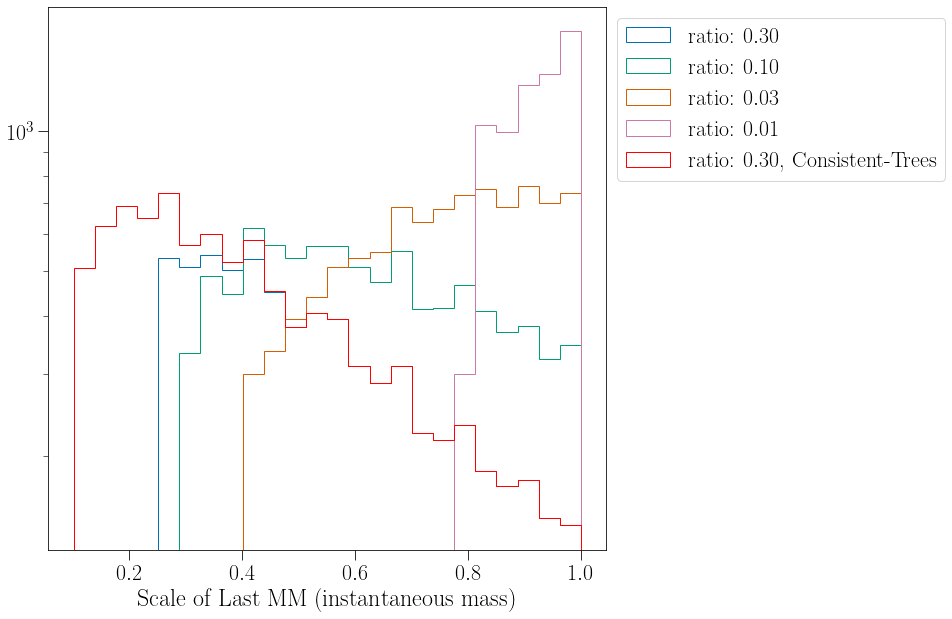

In [68]:
plt.figure(figsize=(10,10))
bins = np.linspace(np.min(scales), np.max(scales), 25)
for k, cutoff in enumerate(cutoff_scales): 
    plt.hist(scale_of_last_MM_inst[:, k], histtype='step', label=f'\\rm ratio: ${Mu[k]/(1-Mu[k]):.2f}$', bins=bins)
    
# ROCKSTAR 
plt.hist(cat['scale_of_last_mm'], histtype='step', label=f'\\rm ratio: $0.30$, Consistent-Trees', bins=bins, color='r')

# formatting
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.yscale('log')
plt.xlabel("\\rm Scale of Last MM (instantaneous mass)")

Text(0.5, 0, '\\rm Scale of Last MM (present-day mass)')

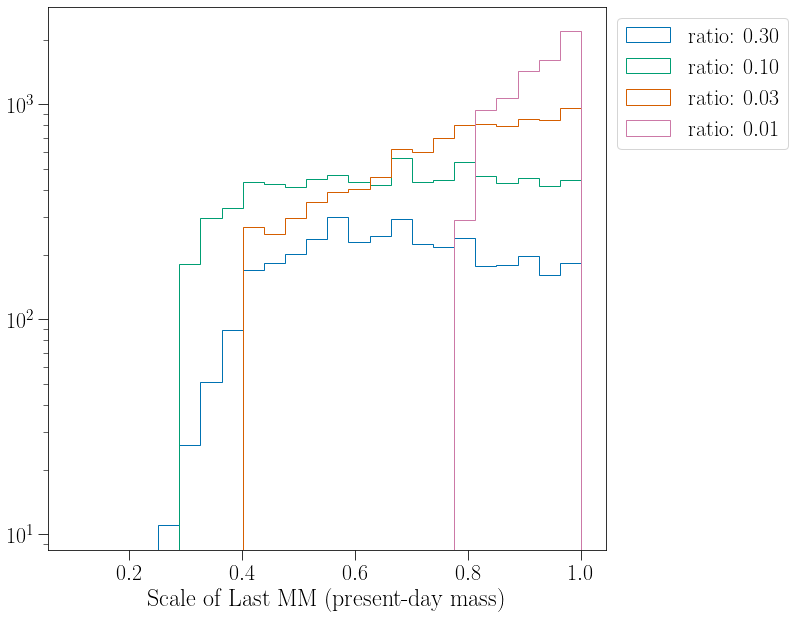

In [20]:
plt.figure(figsize=(10,10))
bins = np.linspace(np.min(scales), np.max(scales), 25)
for k, cutoff in enumerate(cutoff_scales): 
    plt.hist(scale_of_last_MM_present[:, k], histtype='step', label=f'\\rm ratio: ${Mu[k]/(1-Mu[k]):.2f}$', bins=bins)
    
# formatting
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.yscale('log')
plt.xlabel("\\rm Scale of Last MM (present-day mass)")


## Direct ROCKSTAR comparison

6666 7062
2393
6131


Text(0, 0.5, '\\rm Estimate')

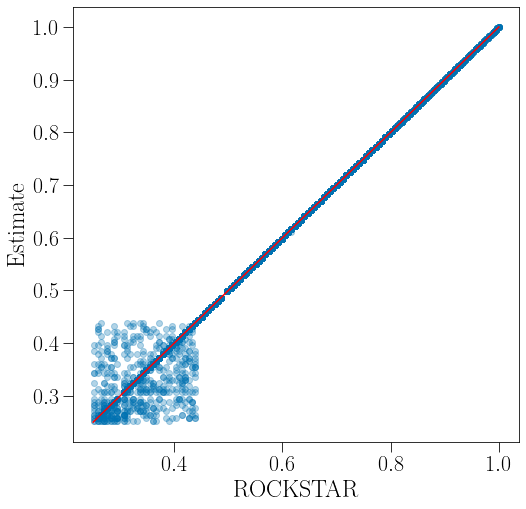

In [69]:
plt.figure(figsize=(8,8))
keep1 = ~np.isnan(scale_of_last_MM_inst[:, 0])
keep2 = cat['scale_of_last_mm'] > 0.25
print(keep1.sum(), keep2.sum())
print(np.sum( (keep1 == keep2) & (keep1 == False) & (keep2 == False)))
keep = keep1 & keep2
print(keep.sum())
plt.scatter(cat['scale_of_last_mm'][keep], scale_of_last_MM_inst[:, 0][keep], alpha=0.3)
plt.plot([0.25, 1],[0.25, 1], c='r')
plt.xlabel(r"\rm ROCKSTAR", size=24)
plt.ylabel(r"\rm Estimate", size=24)

## Check Discrepancy at large scales

In [20]:
weird_bool = (cat['scale_of_last_mm'] > 0.4) & (cat['scale_of_last_mm'] < 0.8) & (scale_of_last_MM_inst[:, 0] > 0.9)
weird_indices = np.arange(len(cat))[weird_bool]


In [21]:
weird_indices

array([1506, 3081, 7002, 8573])

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(scales, ma[weird_idx, :], 'r-x', )
print(weird_idx)

NameError: name 'weird_idx' is not defined

<Figure size 576x576 with 0 Axes>

In [ ]:
len

0.94335
3060462969.0
0.95835
3062514446.0
0.91335
3067645766.0
0.92235
3069695534.0


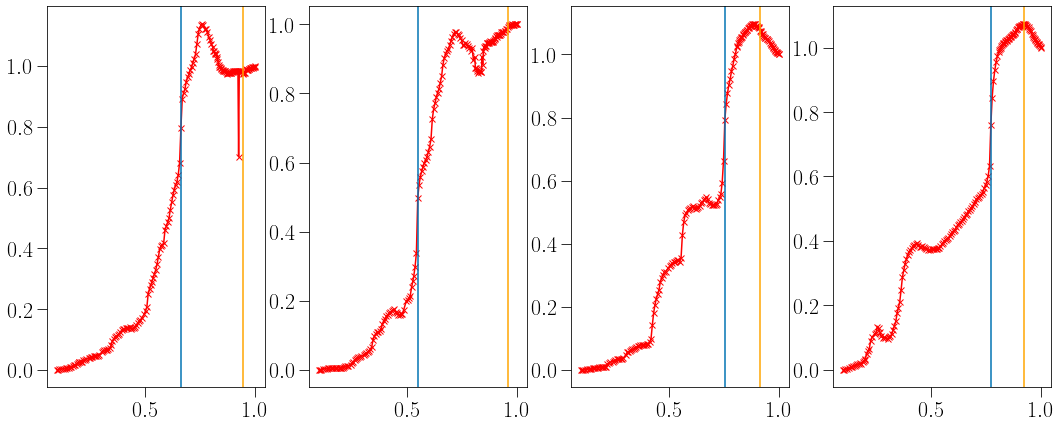

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 7))
axes = axes.flatten()
for i in range(len(axes)): 
    axes[i].plot(scales, ma[weird_indices[i], :], 'r-x', )
    axes[i].axvline(cat['scale_of_last_mm'][weird_indices][i])
    axes[i].axvline(scale_of_last_MM_inst[:,0][weird_indices[i]], color='orange')
    print(scale_of_last_MM_inst[:,0][weird_indices[i]])
    print(cat['id'][weird_indices[i]])

## Debug

array([0.10235, 0.10835, 0.11435, 0.12035, 0.13235, 0.13835, 0.14435,
       0.15035, 0.15635, 0.16235, 0.16835, 0.17435, 0.18035, 0.18635,
       0.19235, 0.19835, 0.20235, 0.20435, 0.21035, 0.21635, 0.22235,
       0.22835, 0.23435, 0.24635, 0.25235, 0.25835, 0.26435, 0.27035,
       0.27635, 0.28235, 0.28835, 0.29435, 0.30635, 0.31235, 0.31835,
       0.32435, 0.33035, 0.33635, 0.34235, 0.34835, 0.35435, 0.36035,
       0.36635, 0.37235, 0.37835, 0.38435, 0.39035, 0.39635, 0.40235,
       0.40835, 0.41435, 0.42035, 0.42635, 0.43235, 0.43835, 0.44435,
       0.45035, 0.45635, 0.46235, 0.46835, 0.47435, 0.48035, 0.48635,
       0.49835, 0.50435, 0.51035, 0.51635, 0.52235, 0.52835, 0.53235,
       0.53835, 0.54435, 0.55035, 0.55635, 0.56235, 0.56835, 0.57435,
       0.58035, 0.58635, 0.59235, 0.59835, 0.60435, 0.61035, 0.61635,
       0.62235, 0.62835, 0.63435, 0.64035, 0.64635, 0.65235, 0.65835,
       0.66435, 0.67035, 0.67635, 0.68235, 0.68835, 0.69435, 0.70035,
       0.70635, 0.71

KeyError: 'z_map'